# Risk assessment for heatwaves based on satellite-derived data

Under climate change, the occurrence of heatwaves is expected to increase in the future in Europe. The main negative impacts caused by heatwave events are related to the overheating of the urban areas, which lowers the comfort of living or causes health issues among vulnerable population (see also: [Integrated Assessment of Urban Overheating Impacts on Human Life](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022EF002682)), drought, and water scarcity. Nowadays, there are a lot of studies and methodologies on how we can mitigate the impacts of these events. This toolbox wants to answer simple questions that are more frequently asked by crisis management local authorities, urban planners, or policymakers. 

These questions are:
   1. What are the problematic areas? (most overheated areas)
   2. Who or what is exposed?

This workflow contains the following steps used to generate a risk map for your selected area:
 - Preparatory work: installing packages and creating directory structure
 - Understanding the trends in the occurence of hot days in the climate change scenarios
 - Identifying the heat islands (areas most exposed to heat) in your selected area, based on the observed land surface temperature (from RSLab Landsat8, resolution: 30x30m)
 - Analysing the distribution of vulnerable population, based on population distribution data. 
 - Creating a heatwave risk map based on the risk matrix where **risk = (level of exposure to heat in the area) x (level of vulnerability)**

## Preparation work

### Importing packages
:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Working with ZIP archive files.
* [os](https://docs.python.org/3/library/os.html) - Handling the current working directory.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - NetCDF and raster processing.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - File system paths.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - API for downloading climate data.
* [numpy](https://numpy.org/doc/stable/) - 2-3D array data handling.
* [xarray](https://docs.xarray.dev/en/stable/) - 2-3D array data handling.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - NetCDF data projection.
* [matplotlib](https://matplotlib.org/stable/) - Data plotting.
* [geopandas](https://geopandas.org/en/stable/) - Geospatial data handling.
* [plotly](https://plotly.com/) - Creating interactive plots.
* [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression) - Linear regression model.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Interactive maps in Jupyter notebooks.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Creating interactive HTML widgets.
* [leafmap](https://leafmap.org/) - Geospatial data visualization and analysis.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Creating tile layers for maps.
* [datetime](https://docs.python.org/3/library/datetime.html) - Handling dates and times.
* [json](https://docs.python.org/3/library/json.html) - Handling JSON data.
* [random](https://docs.python.org/3/library/random.html) - Generating random numbers.
* [requests](https://docs.python-requests.org/en/latest/) - Making HTTP requests.
* [rasterstats](https://pythonhosted.org/rasterstats/) - Zonal statistics for raster data.
* [plotly.express](https://plotly.com/python/plotly-express/) - Creating interactive plots.
* [folium](https://python-visualization.github.io/folium/) - Creating interactive maps.
* [branca](https://python-visualization.github.io/branca/) - Color maps for folium maps.
* [rasterio.transform](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html) - Coordinate transformations for raster data.


In [1]:
import zipfile  # working with the zip folders
import os  # handling the current working directory
import rasterio  # netcdf and raster processing
from pathlib import Path  # file system paths
import cdsapi  # API downloading
import numpy as np  # 2-3D array data handling
import xarray as xr  # 2-3D array data handling
import cartopy.crs as ccrs  # netcdf data projection
import cartopy.feature as cf  # netcdf data projection
import matplotlib as mpl  # data plot
import matplotlib.pyplot as plt  # data plot
from rasterio.crs import CRS  # raster data handling
from pylab import pcolormesh, show, colorbar, plot, title, legend, subplot, savefig  # various plotting functions
from xrspatial.classify import reclassify  # spatial data classification
from matplotlib import pyplot  # data plot
from rasterio.plot import show  # raster data handling
from glob import glob  # file pattern matching
import geopandas as gpd  # geospatial data handling
import rasterio as rio  # raster data handling
from rasterio.transform import from_bounds
import plotly.graph_objects as go  # creating interactive plots
from sklearn.linear_model import LinearRegression  # linear regression model
from ipyleaflet import Map, DrawControl, Marker, LayersControl, LegendControl, GeoData, GeoJSON, WidgetControl  # interactive maps
import ipywidgets as widgets  # creating interactive widgets
import leafmap.leafmap as leafmap  # mapping library
from localtileserver import get_leaflet_tile_layer, TileClient  # creating tile layers for maps
from datetime import datetime, timedelta  # handling dates and times
import json  # handling JSON data
import random  # generating random numbers
import requests  # making HTTP requests
import rasterstats  # zonal statistics for raster data
import plotly.express as px  # creating interactive plots
import folium  # creating interactive maps
from folium.raster_layers import ImageOverlay  # raster layer for folium maps
from folium import LayerControl  # layer control for folium maps
from branca.colormap import linear  # color maps for folium maps
import pandas as pd


c:\Users\aleksand\AppData\Local\mambaforge\envs\climaax_heatwaves\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Create directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heatwave_risk'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
LST_dir = os.path.join(workflow_folder,'data','LST')
pop_dir = os.path.join(workflow_folder,'data','population')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(LST_dir))
    os.makedirs(os.path.join(pop_dir))
    os.makedirs(os.path.join(results_dir))

## Understanding trends in the occurence in hot days/nights under climate change

Data from climate models (EURO-CORDEX or CMIP6) is too coarse to be used directly in an assessment of overheated areas in urban environment. However, in a climate risk assessment, it is important to understand the influence of climate change on the probability of heatwave occurrence in the future relative to the present climate. You can use the results from the heatwave hazard assessment workflow (applied to your area) or use other data sources available online, where heatwave occurance data is provided on regional level.

On the website of [Climate-ADAPT](https://climate-adapt.eea.europa.eu/en) we can find information on the future occurrence of hot days at NUTS2 level. The content in the European Climate Data Explorer pages is delivered by the Copernicus Climate Change Service (C3S) implemented by ECMWF. You can explore this data in the following links:
 - [**Heat days occurence in the past**](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days)
 - [**Heat days occurence in the future**](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days)
 - [**Tropical night past and projections**](https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/)

## Identifying overheated areas in the urban environment

### Data description and download

**Heat islands** are urbanized areas that experience higher temperatures than surrounding areas. Structures such as buildings, roads, and other infrastructure absorb and re-emit the sun’s heat, thus resulting in warmer temperatures than in the natural landscapes (such as forests and water bodies). Urban areas, where these structures are highly concentrated and greenery is limited, become “islands” of higher temperatures relative to outlying areas (see also: [Heat islands definition](https://www.epa.gov/heatislands)).
For the identification of the heat islands from the historical data we can use these data:

**Satellite-derived land surface temperature data** in this workflow is based on the Landsat8 land surface temperature (LST) (spatial resolution: 15-30m; at 8-16 days interval). We use this data product for the identification of the heat islands. The LST product is available on the RSLAB website or can be calculated from the L8 imagery bands.

For this workflow, land surface temperature data needs to be **manually downloaded** from the [RSLab portal](https://rslab.gr/Landsat_LST.html). To do this, you need to follow these steps:
1. Go to the [RSLab portal](https://rslab.gr/Landsat_LST.html) and draw a closed polygon around your area of interest by zooming in and clicking on the map. If you are focusing on urban areas, it is important to try to select only the urban areas in the rectangular polygon.
2. Select the time period, e.g. June to August in a specific year, where particularly high temperatures were observed. From Landsat8, data is available for 2013-2021, it is recommended to choose a year in this period (optional: consult the local meteorological authorities for more information on past heat waves). 
3. Select your preferred Landsat source and emissivity. For the dates in the period 2013-2021, please choose Landsat8 as the source. For urban areas, it is recommended to use MODIS and NDVI-based emissivity (ASTER emissivity is preferred for natural landscapes). Refer to the [documentation](https://www.mdpi.com/2072-4292/9/12/1208) for more details.
4. Click the "Calculate LST" button.
5. The results will be presented below the map. For each LST result you will find a "show" and "download" buttons. "Show" button allows to display the LST as a layer on the map and calculates the mean/min/max LST value for the selected image. 
6. To dowload the images, please press "Download - All images", this will start the download of the "AllImages_LST.zip" file that contains .tiff images. 
7. Once downloaded, please move the downloaded file to the folder specified above under variable *LST_dir* (folder *./Heatwave_risk/data_dir/LST*).

`````{admonition} For advanced users
:class: hint dropdown
RSLab portal only gives access to the data up to 2021. If you need to access more recent data, you can also retrieve LST data for other years by calculating it directly from the raw Landsat8 imagery. Please check the following resources:  
 - [Landsat8 raw imagery download](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)
 - [How to calculate of the LST (YouTube video)](https://www.youtube.com/watch?v=hd7fscNTff4).

 The processing of this data is demonstrated below in the section **Alternative for advanced users: Calculation of the Landsat LST from Landsat 8/9 imagery (alternative to RSLab data)**.
`````

This code unzips all downloaded LST data:

In [3]:
# Loop through all files in the directory
for file in os.listdir(LST_dir):
    file_path = os.path.join(LST_dir, file)
    # Check if the file is a zipfile
    if zipfile.is_zipfile(file_path):
        # Open the zipfile
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zipfile into the working directory
            zip_ref.extractall(LST_dir)

The code below extracts all dates from LST data files:

In [4]:
# Create a list of file paths to your LST files using glob
L8list = glob(f"{LST_dir}/*LST*.tif")
# Initialize an empty list to store the datetime objects
lst_dates = []
# Loop through each filename
for file in L8list:
    # Extract the filename without the directory path
    filename = file.split('/')[-1]   
    # Extract the date and time part from the filename
    if "AllImages_LST" in filename:
        date_time_str = filename.split('.')[1]
        date_str = date_time_str.split('_')[0]
        time_str = date_time_str.split('_')[1]
    else:
        date_str = filename[4:12]  # Extract date part directly
        time_str = filename[13:19]  # Extract time part directly    
    # Combine date and time strings into a single string
    datetime_str = date_str + '_' + time_str    
    # Convert the combined datetime string to a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')   
    # Append the datetime object to the lst_dates list
    lst_dates.append(datetime_obj)
lst_dates

[datetime.datetime(2020, 6, 13, 10, 33, 29),
 datetime.datetime(2020, 6, 20, 10, 39, 43),
 datetime.datetime(2020, 6, 29, 10, 33, 37),
 datetime.datetime(2020, 7, 6, 10, 39, 51),
 datetime.datetime(2020, 7, 15, 10, 33, 43),
 datetime.datetime(2020, 7, 22, 10, 39, 56),
 datetime.datetime(2020, 7, 31, 10, 33, 48),
 datetime.datetime(2020, 8, 7, 10, 40),
 datetime.datetime(2020, 8, 16, 10, 33, 52),
 datetime.datetime(2020, 8, 23, 10, 40, 7)]

In [5]:
# List all files containing LST data
L8list = glob(f"{LST_dir}/*LST*.tif")

This code will create a raster stack from all downloaded data:

In [6]:
# Load the data and create a raster stack from all maps
with rasterio.open(L8list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(L8list))
# Save a data to working directory
with rasterio.open(f'{data_dir}/L8_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(L8list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

This code calculates mean values from the LST rasters which are not significantly influenced by clouds:

In [7]:
# Open the raster stack
stack_path = f'{data_dir}/L8_raster_stack.tif'
raster_dataset = xr.open_dataset(stack_path)
# Count the number of pixels greater than 0 for each band
num_pixels_gt_zero = (raster_dataset > 0).sum(dim=('x', 'y'))
# Calculate the total number of pixels for each band
total_pixels = raster_dataset.sizes['x'] * raster_dataset.sizes['y']
# Calculate the proportion of pixels greater than 0
prop_gt_zero = num_pixels_gt_zero / total_pixels
# Filter bands where at least 50% of pixels are greater than 0
filtered_bands = raster_dataset.where(prop_gt_zero >= 0.5)
# Calculate the mean values for the filtered bands
mean_values_filtered = filtered_bands.mean(dim=('x', 'y'))
#mean_values_filtered = mean_values_filtered.fillna(0)
mean_values_filtered=mean_values_filtered['band_data']
mean_values_list = mean_values_filtered.values.tolist()

### Classifying the LST values based on the LST temperature


In this step, we will divide the LST data into 5 categories based on the temperature:
  
  1. **Very low** < 30°C
  2. **Low** > 30°C
  3. **Medium** > 35°C
  4. **High** > 40°C
  5. **Very High** > 45°C

  **Note:** If needed, you can change the threshold values for each category to see more of a difference between the different areas in the city.
     
**Important:** The LST values represent the surface temperature, not the air temperature. The surface temperature reaches higher values than the air temperature. The ground surface temperature is an important influencing factor for the weather as it is perceived by humans. The temperature of the ground surface can be more than 10°C higher than the air temperature on a sunny day, and up to 10°C below air temperature on clear nights when the surface loses heat by radiation. (see also: [Land surface temperature vs air temperature](https://caas.usu.edu/weather/graphical-data/surface-temperature)).



In [8]:
# Define classes for grouping LST data
lc_bins = [30, 35, 40, 45]  
lc_values = [1, 2, 3, 4, 5]

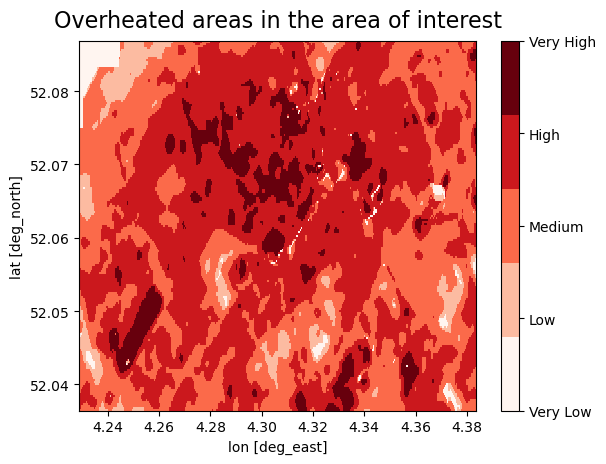

In [9]:
# Load the data and calculate maximum values from raster stack
L8_path = f'{data_dir}/L8_raster_stack.tif'
L8 = xr.open_dataset(L8_path)
L8 = L8.max(dim='band', skipna=True, keep_attrs=True)
L8lst2016 = L8['band_data']
lstbbox = L8.rio.bounds()

# Function to reclassify data using numpy
def reclassify_with_numpy(array, bins, new_values):
    reclassified_array = np.zeros_like(array)
    reclassified_array[array < bins[0]] = new_values[0]
    for i in range(len(bins) - 1):
        reclassified_array[(array >= bins[i]) & (array < bins[i + 1])] = new_values[i + 1]
    reclassified_array[array >= bins[-1]] = new_values[-1]
    return reclassified_array

# Apply the reclassification function
lc_class = reclassify_with_numpy(L8lst2016.values, bins=lc_bins, new_values=lc_values)

# Convert the reclassified array back to xarray DataArray for plotting
lc_class_da = xr.DataArray(lc_class, coords=L8lst2016.coords, dims=L8lst2016.dims)

# Plot the data
fig, ax = plt.subplots()
cmap = plt.get_cmap('Reds', 5) 
oa = lc_class_da.plot(ax=ax, cmap=cmap, add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Overheated areas in the area of interest', size=16, pad=10)
plt.show()

### Alternative for advanced users: Calculation of the Landsat LST from Landsat 8 - 9 imagery (alternative to RSLab data)

If you need to access the more recent data (2022 onwards) you will need to follow an alternative data retrieval that involves more calculations.

**Note: You do not need to calculate this step for data in the period 2013-2021, because you can download this data from [RSLab](https://rslab.gr/Landsat_LST.html) as it was done above. Therefore you can skip this section if you are using the RSLab data for Landsat8.**

In this section we demonstrate an example of the calculation of the land surface temperature from Landsat 8 - 9 imagery raw data from the European Space Agency.
For the data download you need to choose the level of the data L1 or L2.
 - L1 level contains all 11 bands
 - L2 level contains bands 1-7 and band 10
 
We need to download and process the Landsat 8-9 data. This data is downloded from the [ESA data catalog](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage). Instructions for downloading the data can be found in these videos: 
 - [Landsat 9 data download per-processing and LST calculation (YouTube)](https://www.youtube.com/watch?v=Eug32jeK8Gw)
 - [Calculating Land Surface Temperature Using Landsat 8 Imagery (YouTube)](https://www.youtube.com/watch?v=hd7fscNTff4).

 The code below shows how the data can be processed, starting with the *b10* variable. 

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

# Emisivity
emi=0.004*pv+0.986

# Land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

### Plot the observed maximum 2m air temperature together with LST temperature

- We display the measured data of the 2m air temperature together with the LST data, to see for which days we downloaded the LST data.
- This step will give us the information if we downloaded the data for the days with the highest air temperature. 

In [10]:
# Create a dictionary from your data
data = {'Dates': lst_dates, 'Values': mean_values_list}
# Create a DataFrame from the dictionary

df = pd.DataFrame(data)
# Plot using Plotly Express
fig = px.scatter(df, x='Dates', y='Values', labels={'Dates': 'Date', 'Values': 'LST Mean Values'}, color='Values')
fig.update_traces(marker=dict(color='green'))  # Set dot color to green
fig.update_traces(mode='markers')  # Display as dots
# Add title and center it
fig.update_layout(title_text='LST mean values (cloud coverage<50%)',
                  title_x=0.5,  # Center the title horizontally
                  title_y=0.9)  # Adjust vertical position if needed
fig.update_xaxes(tickformat='%d-%m-%Y')
fig.show()

This plot gives you the information about land surface temperature mean values for the selected area, per Landsat8 image. Only the days corresponding to the LST pictures with cloud coverage lower then 50% are plotted.

## Identify vulnerable population groups 

We can now use the maps of population distribution and combine these with LST maps to assess how the most populated areas overlap with the most overheated areas. 

The default option in this workflow is to retreive the population data from the WorldPop dataset. 

`````{admonition} Using your own data for population and infrastructure
:class: hint dropdown
For a more accurate assessment, it is advisable to use local data for the vulnerable population. For example, for the Zilina pilot in the CLIMAAX project, we collected data from the Zilina municipality office about the buildings that are usually crowded with huge masses of people, e.g. hospitals, stadiums, main squares, big shopping centers, main roads, and bigger factories. If places like these are overheated, a huge number of people can be negatively influenced by the heat. Therefore, the risk also becomes higher and it would be most effective to prioritize these areas when working on heat mitigation measures.  
`````

### Download the vulnerable population data 

 1. Go to the [portal for accessing WorldPop data](https://data.humdata.org/dataset/?dataseries_name=WorldPop%20-%20Age%20and%20sex%20structures&groups=esp&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25):
       -  Select the **WorldPop-Age and sex structures**
       -  Select the **Location**
       -  Select the **Formats** to GeoTIFF.
 2. Download the maps for the most vulnerable groups of the population. This is done by manually downloading the relevant files. The data files have names according to the following pattern: **[country code]**\_**[sex]**\_**[age]**_2020.tif. 
 For example, svk_m_1_2020.tif =
     -  svk = Slovakia
     -  m = male (please download both male and female (f))
     -  1 = 1 to 5 years of age, download also for 65, 70, 75, 80
     -  2020 = age structures in 2020 
 3. Copy the data into the directory that was defined earlier (*pop_dir* variable,  or *./Heatwave_risk/data/population/*).
 
 
Now we can use the below code to do the following:
- load all the maps of the vulnerable population (based on age)
- calculate the sum of the vulnerable population across ages and sexes
- classify the population data into 5 groups (equal intervals)
- plot it next to a map of overheated areas

### Process population data

First we will load the population data:

In [11]:
# This code loads all population data and creates a raster stack from them 
poplist = glob( f'{pop_dir}/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

Now we can classify the vulnerable population data into 5 groups based on the spatial density of this subset of the population: 

In [ ]:
# Load the LST data and calculate maximum values from raster stack
L8_path = f'{data_dir}/L8_raster_stack.tif'
L8 = xr.open_dataset(L8_path)
L8 = L8.max(dim='band', skipna=True, keep_attrs=True)
L8lst2016 = L8['band_data']
lstbbox = L8.rio.bounds()

# Load the population data and calculate the sum from raster stack
pop_path = f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop_path)
pop = pop.sum(dim='band', skipna=True, keep_attrs=True)
pop = pop['band_data']
pop = pop.rio.clip_box(minx=lstbbox[0], miny=lstbbox[1], maxx=lstbbox[2], maxy=lstbbox[3])

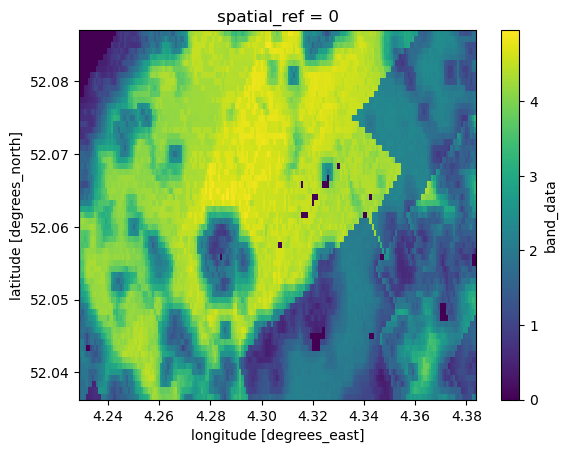

In [20]:
# check the distribution of the data across the selected domain
pop.plot()

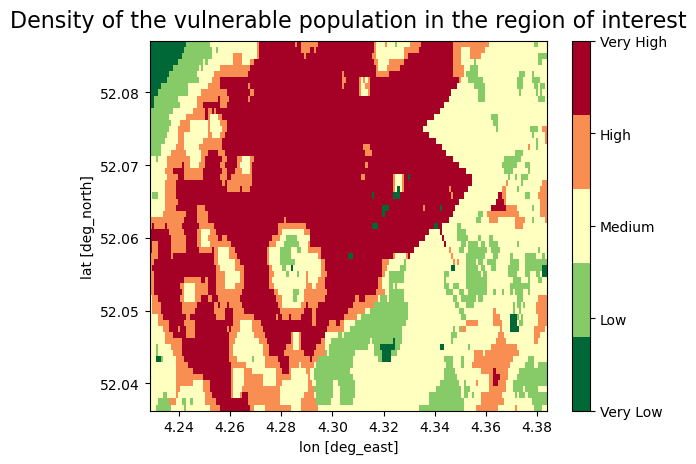

In [42]:
# Function to reclassify data using numpy
def reclassify_with_numpy(array, bins, new_values):
    reclassified_array = np.zeros_like(array)
    reclassified_array[array <= bins[0]] = new_values[0]
    for i in range(len(bins) - 1):
        reclassified_array[(array > bins[i]) & (array <= bins[i + 1])] = new_values[i + 1]
    reclassified_array[array > bins[-1]] = new_values[-1]
    return reclassified_array

# Calculate the number of bins (classes)
num_bins = 4

# Equal interval classification
min_value = np.nanmin(pop)  # Minimum population value
max_value = np.nanmax(pop)  # Maximum population value

bin_width = (max_value - min_value) / num_bins  # Width of each bin
pop_bins = [min_value + i * bin_width for i in range(num_bins)]  # Define bin boundaries

# alternative to calculating pop_bins using a threshold to only make bins within the urban (more densely populated) area:
#thresh_value = 3.2
#bin_width = (max_value - min_value) / num_bins  # Width of each bin
#pop_bins = [min_value]
#tmp = [thresh_value + i * bin_width for i in range(num_bins)]
#pop_bins = pop_bins + tmp

# Define classes
pop_values = [1, 2, 3, 4, 5]

# Apply the reclassification function to the population data
pop_class = reclassify_with_numpy(pop.values, bins=pop_bins, new_values=pop_values)

# Convert the reclassified array back to xarray DataArray for plotting
pop_class_da = xr.DataArray(pop_class, coords=pop.coords, dims=pop.dims)

# Plot the data
fig, ax = plt.subplots()
cmap = plt.get_cmap('RdYlGn_r', 5) 
oa = pop_class_da.plot(ax=ax, cmap=cmap, add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Density of the vulnerable population in the region of interest', size=16, pad=10)
plt.show()

### Plot maps of the overheated areas next to the map of vulnerable population density

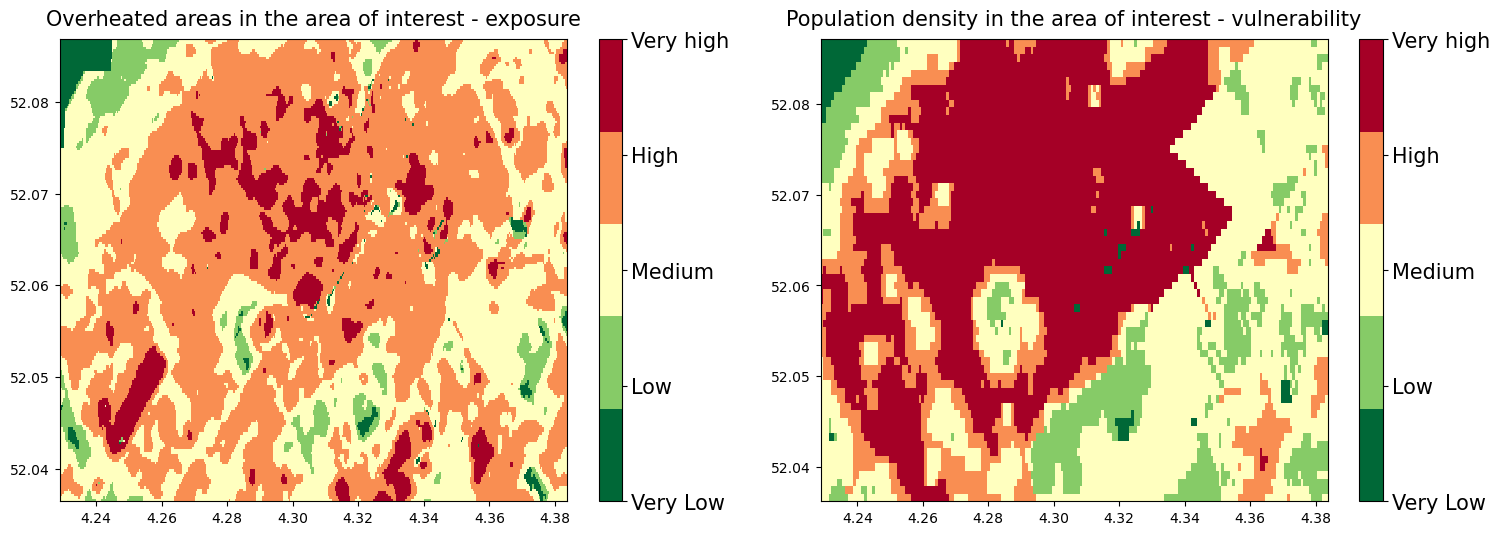

In [45]:
# This plots the overheated areas and population density maps
fig, axes=plt.subplots(ncols=2, figsize=(18,6))
cmap = plt.get_cmap('RdYlGn_r', 5) 
# Plot a data
oa1 = lc_class_da.plot(ax = axes[0], cmap=cmap, add_colorbar=False)
cbar = fig.colorbar(oa1, ticks=[ 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Overheated areas in the area of interest - exposure', size=15, pad = 10)
# Plot a data
oa2 = pop_class_da.plot(ax = axes[1], cmap=cmap, add_colorbar=False)
cbar = fig.colorbar(oa2, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Population density in the area of interest - vulnerability', size=15, pad = 10)
plt.draw()

On the plot above we can see the most overheated areas next to the density of the vulnerable population groups
The data behind these maps was classified into 5 groups. This will now be used to calculate a risk map, using the risk matrix below.

![heatwave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/risk_matrix.png?raw=true "Risk matrix example")

### Save data LST and population map

In [46]:
# This code saves the data to results_dir
lc_class_da.rio.to_raster(raster_path=f'{results_dir}/risk_LST.tif')
pop_class_da.rio.to_raster(raster_path=f'{results_dir}/risk_pop.tif')

## Calculate the heatwave risk map 

In this step we calculate the heatwave **risk** map based on the **exposure (LST - areas that heat up most)** x **vulnerability (density of vulnerable population)**. This risk map would then be based on historical data, and some interpretation is still needed to translate this result to future risk (see more information on this in the conclusions).

### Load data and create a raster stack

In [47]:
# This code creates a raster stack from risk_LST and risk_pop data, we need this step for the next processing of the data 
S2list = glob( f'{results_dir}/risk_*.tif')
#
with rasterio.open(S2list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(S2list))
#
with rasterio.open(f'{results_dir}/risk_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(S2list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

### Calculate the risk 

Text(0.5, 1.0, 'heatwave risk level')

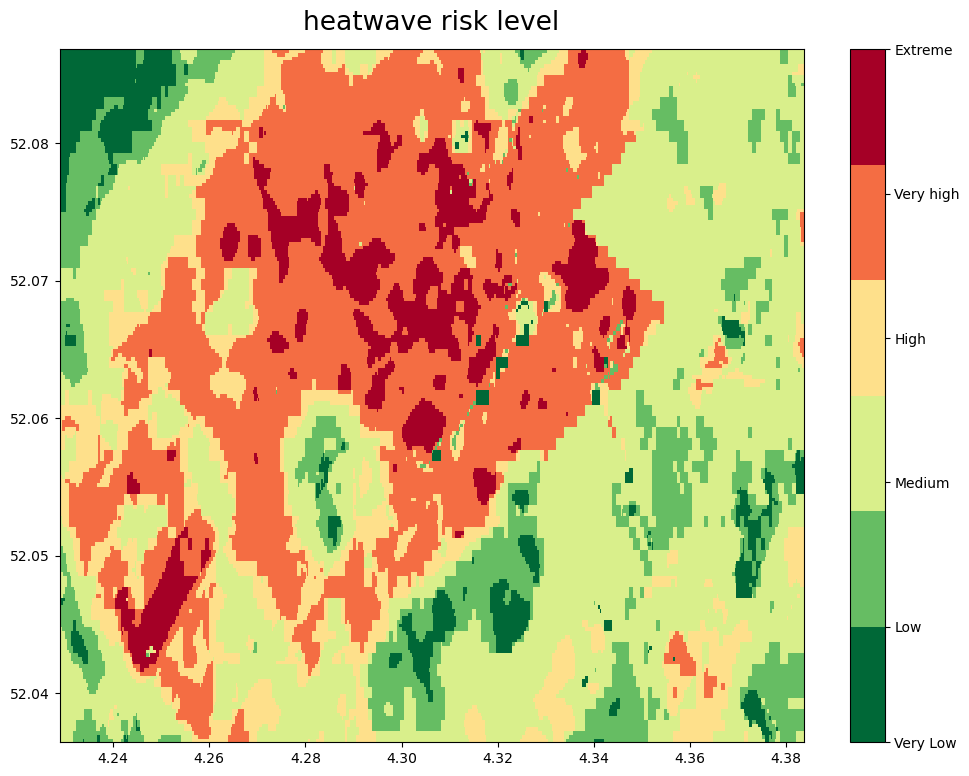

In [50]:
# This code calculates a risk map by multiplying a risk_LST and risk_pop data 
risk=f'{results_dir}/risk_raster_stack.tif'
risk = xr.open_dataset(risk)
risk=risk['band_data']
risk=(risk[0])*(risk[1])
# Plot a data
fig, ax = plt.subplots(figsize=(12, 9))

cmap = plt.get_cmap('RdYlGn_r', 6) 
oa3 = risk.plot(ax = ax, cmap=cmap, add_colorbar=False)
cbar = fig.colorbar(oa3, ticks=[1, 5, 10, 15, 20, 25])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high', 'Extreme'], size=10)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('heatwave risk level', size=19, pad = 14)

#ci= CI_WGS.plot(ax=ax, color='blue', alpha=0.3)

### Save the risk map 

In [51]:
# This code saves the risk identification map in the results_dir
risk.rio.to_raster(raster_path=f'{results_dir}/Heatwave_risk_identification_map.tif')

Based on the risk interpretation map (above), we can identify the places most influenced by the heatwaves (dark red), for better visualization we can load a map with leafmap (below).

### Plot Risk data on the interactive map

To see these maps on the interactive zoom in/out map with the Open Street Base map run the code below.

In [54]:
# This code creates a tile client from risk maps
# First, create a tile server from local raster file
riskpop = TileClient(f'{results_dir}/risk_pop.tif')
riskLST = TileClient(f'{results_dir}/risk_LST.tif')
HWRI = TileClient(f'{results_dir}/Heatwave_risk_identification_map.tif')

In [61]:
# This code creates ipyleaflet tile layer from that server
tpop = get_leaflet_tile_layer(riskpop, cmap='Reds',opacity=0.7, nodata=0, name='Risk population')
tLST = get_leaflet_tile_layer(riskLST, cmap='bwr',opacity=0.7, nodata=0, name='LST')
tHWRI = get_leaflet_tile_layer(HWRI, cmap='RdYlGn_r',opacity=0.7, nodata=0, name='Heat wave risk identification')

In [63]:
# This code plots the results on the ipyleaflet map 

# Set the size of the map
map_layout = widgets.Layout(width='1100px', height='800px')

# This code plots all loaded rasters and vectors on the ipyleaflet map
m = Map(center=riskLST.center(), zoom=riskLST.default_zoom, layout=map_layout)

control = LayersControl(position='topright')

m.add(tpop)
m.add(tLST)
m.add(tHWRI)

labels = ["Very low", "Low", "Medium", "Very high", "Extreme"]
colors = [(0, 104, 55), (35, 132, 67), (255, 255, 191), (255, 127, 0), (215, 25, 28)]

# Create legend HTML content with custom styles (smaller size)
legend_html = "<div style='position: absolute; bottom: 2px; left: 2px; padding: 10px; " \
              "background-color: #FFF; border-radius: 10px; box-shadow: 2px 2px 2px rgba(0,0,0,0.5); " \
              "width: 75px; height: 205px; '>"

# Append legend items (labels with colored markers)
for label, color in zip(labels, colors):
    color_hex = '#%02x%02x%02x' % color  # Convert RGB tuple to hex color
    legend_html += f"<p style='font-family: Arial, sans-serif; font-size: 14px; '>" \
                   f"<i style='background: {color_hex}; width: 10px; height: 10px; display: inline-block;'></i> {label}</p>"

legend_html += "</div>"

# Create a custom widget with the legend HTML
legend_widget = widgets.HTML(value=legend_html)

legend_control = WidgetControl(widget=legend_widget, position='bottomleft')
m.add_control(legend_control)

m.add(control)
#m.add(geo_json1)

m

Map(center=[52.06163771232584, 4.306253977483751], controls=(ZoomControl(options=['position', 'zoom_in_text', …

**How to use the map**: You can add or remove a map by "click" on the "layer control" in the top right corner, or "Zoom in/out" by "click" on the [+]/[-] in the top left corner 
We recommend first unclicking all the maps and then displaying them one by one, the transparency of the maps allows you to see which areas on the OpenStreetMap are most exposed to the heat, and in combination with the distribution of the vulnerable population, you can identify which areas should be prioritized for the application of the heat mitigation measures.

## Conslusion for the Risk identification results

The results of the risk workflow help you identify the places that are the most exposed to the effects of heat in combination with the map of areas with high density of vulnerable groups of population (based on age).

Together with the results of the hazard assessment workflow that gives you the information both on future heatwave occurences and most vulnerable areas to the heatwaves.

![Heat-wave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/hw_year_pesetaiv.png?raw=true "Risk matrix example")

**Important: **
There are important limitations to this analysis, associated with the source datasets:
  - The Land surface temperature data is derived from the Landsat 8 satellite imagery and data of acceptable quality (without cloud cover) is only available for a limited number of days. That means that we get limited information on the maximum LST (past heatwaves are not always captured in the images from Landsat8). The resolution of the 30x30m also has its limitations, especially in the densely built-up areas.
  - The world population data are available for 2020, and the distribution of the population may have changed (and will continue to change). Moreover, WorldPop data is based on modelling of populations distributions and not on local census data, therefore it may be inaccurate. Use of local data may help to reduce this uncertainty.
 


## 9: References

- Climate adapt, Apparent temperature heatwave days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days [2024-06-17].

- Climate adapt, Tropical nights (2021), https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/ [2024-06-17].

- Climate adapt, High UTCI Days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days [2024-06-17].

- humdata.org, High Resolution Population Density Maps + Demographic Estimates (2020), https://data.humdata.org/dataset/albania-high-resolution-population-density-maps-demographic-estimates [2024-06-20]

- European Space Agency ESA, Landsat 8 satellite imagery (2013), https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage [2024-06-20]

- Utah Space University, Difference between Air and surface temperature (2024), https://caas.usu.edu/weather/graphical-data/surface-temperature [2024-06-20]

- United States Environmental Protection Agency EPA, Heat Island Effect (2024), https://www.epa.gov/heatislands [2024-06-20]

- Nazarian, N., Krayenhoff, E. S., Bechtel, B., Hondula, D. M., Paolini, R., Vanos, J., Cheung, T., Chow, W. T. L., de Dear, R., Jay, O., Lee, J. K. W., Martilli, A., Middel, A., Norford, L. K., Sadeghi, M., Schiavon, S., Santamouris, M. (2022), Integrated Assessment of Urban Overheating Impacts on Human Life, Earth’s Future, 10(9). https://doi.org/10.1029/2022EF002682

- Parastatidis D, Mitraka Z, Chrysoulakis N, Abrams M. Online Global Land Surface Temperature Estimation from Landsat. Remote Sensing. (2017); 9(12):1208. https://doi.org/10.3390/rs9121208

- RSLAB, Land surface temperature, based on the Landsat8 imagery, https://rslab.gr/Landsat_LST.html [2024-06-20]

## 10: Authors 

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)
- Natalia Aleksandrova, Deltares (review and editing)